In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from math import factorial
import random
import math
from tqdm import tqdm
from sklearn import model_selection 
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp
from scipy.stats import norm, mannwhitneyu, chi2_contingency

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

### Задание 1

Написать запрос, который позволит
определить для каждой версии приложения интерквартильное среднее (IQM)
времени игры в первые три дня с момента регистрации по пользователям,
зарегистрированным в декабре

In [ ]:
# IQM считал как среднее арифметическое для значений между 0.25 и 0.75 процентилем
with version_quanitles as (select app_version
                                , quantileExact(0.25)(age) as q1     
                                , quantileExact(0.75)(age) as q3
                        from table                        
                        where user_created_on between '2022-12-01' and '2022-12-31'  
                                and day <= date_add(day, 2, user_created_on)   
                        group by app_version
                        )

select t.app_version as app_version
        , avg(t.play_time) as d3_play_time_iqm
from table as t 
join version_quanitles as vq 
    on t.app_verion = vq.app_verstion

where t.user_created_on between '2022-12-01' and '2022-12-31'   
    and t.day <= date_add(day, 2, t.user_created_on)      
    and t.play_time between vq.q1 and vq.q3                     
group by t.app_version


### Задание 2

Написать запрос, который позволит определить чистую легкость топ-10
вопросов по лайкрейту

In [ ]:
with template as (  select user_id
                        , question_id
                        , if(actoin_name = 'answer', 1, 0) as is_answer       
                        , if(action_descr = 'right', 1, 0) as is_right
                        , multiIf(action_descr = 'like', 1, action_descr = 'dislike', -1, 0) as is_like_dislike
                    from table2 
                ),

    -- посчитаем likerate и пронумеруем по likerate
    likerate as (select question_id
                        , likerate
                        , row_number() over (order by likerate desc) as rn
                from (  select question_id
                                , sum(is_like_dislike) / sum(is_answer) as likerate                                 
                        from template
                        group by question_id                      
                        ) as subq

select question_id
        , sum(is_right) / sum(is_answer) as clear_easiness
from template as t
join likerate as lr
    on t.question_id = lr.question_id
        and lr.rn <= 10                                                  
left join (select distinct user_id, question_id          -- отсекаем пользователей, которые применили подсказку на вопрос
           from table2
           where action_name = 'use_hint')  as uh
    on t.user_id = uh.user_id
        and t.question_id = uh.user_id

where uh.user_id is null   -- кажется, в зависимости от настроек в CH null может выводиться как 0, тогда условие uh.user_id = 0
group by t.question_id
order by lr.rn 


### Задание 3

In [22]:
dfe = pd.read_csv('task_3.csv')
dfe = dfe.rename(columns={'Unnamed: 0': 'index'})
dfe.head()

,index,age,gender,language_group,preset_group,ad_interstitial_starts,ad_rewarded_starts,retention_D1,UsersQuestionRightAnswersPerAnswers,revenue_interstitial_D0D3,revenue_rewarded_D0D3
0,0,7,NaN,android_fr,base,0.0,0.0,0,NaN,NaN,NaN
1,1,12,f,android_fr,base,3.0,0.0,0,96.153846,0.012230,0.000000
2,2,42,f,android_fr,base,20.0,0.0,1,93.670886,0.009349,0.000000
3,3,77,f,android_fr,base,10.0,8.0,0,91.250000,0.127331,0.081907
4,4,15,f,android_fr,base,0.0,0.0,0,91.666667,0.001250,0.000000


In [23]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105348 entries, 0 to 105347
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   index                                105348 non-null  int64  
 1   age                                  105348 non-null  int64  
 2   gender                               89793 non-null   object 
 3   language_group                       105348 non-null  object 
 4   preset_group                         105348 non-null  object 
 5   ad_interstitial_starts               105348 non-null  float64
 6   ad_rewarded_starts                   105348 non-null  float64
 7   retention_D1                         105348 non-null  int64  
 8   UsersQuestionRightAnswersPerAnswers  95496 non-null   float64
 9   revenue_interstitial_D0D3            82447 non-null   float64
 10  revenue_rewarded_D0D3                82315 non-null   float64
dtypes: float64(5)

В данных много пропусков в последних трех полях. Кажется, что значение выручки отсутсвующее можно заполнить нулем, звучит логично (хотя мне неизвестна природа этих пропусков).  Метрику UsersQuestionRightAnswersPerAnswers можно было бы заполнить средним, например. Но не факт, что это корректно, ведь это, должно быть, люди, которые не отвечали на вопросы. Оставлю значения пропущенными.

In [24]:
dfe.revenue_interstitial_D0D3 = dfe.revenue_interstitial_D0D3.fillna(0)
dfe.revenue_rewarded_D0D3 = dfe.revenue_rewarded_D0D3.fillna(0)

In [25]:
# количество пользователей в каждом эксперименте
dfe.preset_group.value_counts()

base     35116
exp_1    35116
exp_2    35116
Name: preset_group, dtype: int64

Поскольку у нас нет гипотезы для сравнения, стоит ее сформулировать. Думается, что ключевые для нас поля это два последние поля связанные с revenue, то есть с нашим доходом. Считаю, чтобы не множить сущности, есть смысл упростить эксперимент, объединив эти поля в одно. Тогда мы будем сравнивать совокупный revenue для трех вариантов эксперимента

In [26]:
dfe['revenue'] = dfe.revenue_interstitial_D0D3 + dfe.revenue_rewarded_D0D3

In [27]:
# поделим датафреймы в соответсвии с экспериментом
dfb = dfe[dfe.preset_group == 'base'] 
dfe1 = dfe[dfe.preset_group == 'exp_1'] 
dfe2 = dfe[dfe.preset_group == 'exp_2'] 

Данные характеризуются большим количеством нулевых значений (около 20% для совокупного revenue), а также длинным правым хвостом, редкими высокими значениями. Из-за этого гистограмма распределения выглядит неинформативно. Для иллюстрации я построю гистограмму распределения логарифма от revenue. Это позволит сгладить очень высокие значения и получить некоторую визуализацию

''

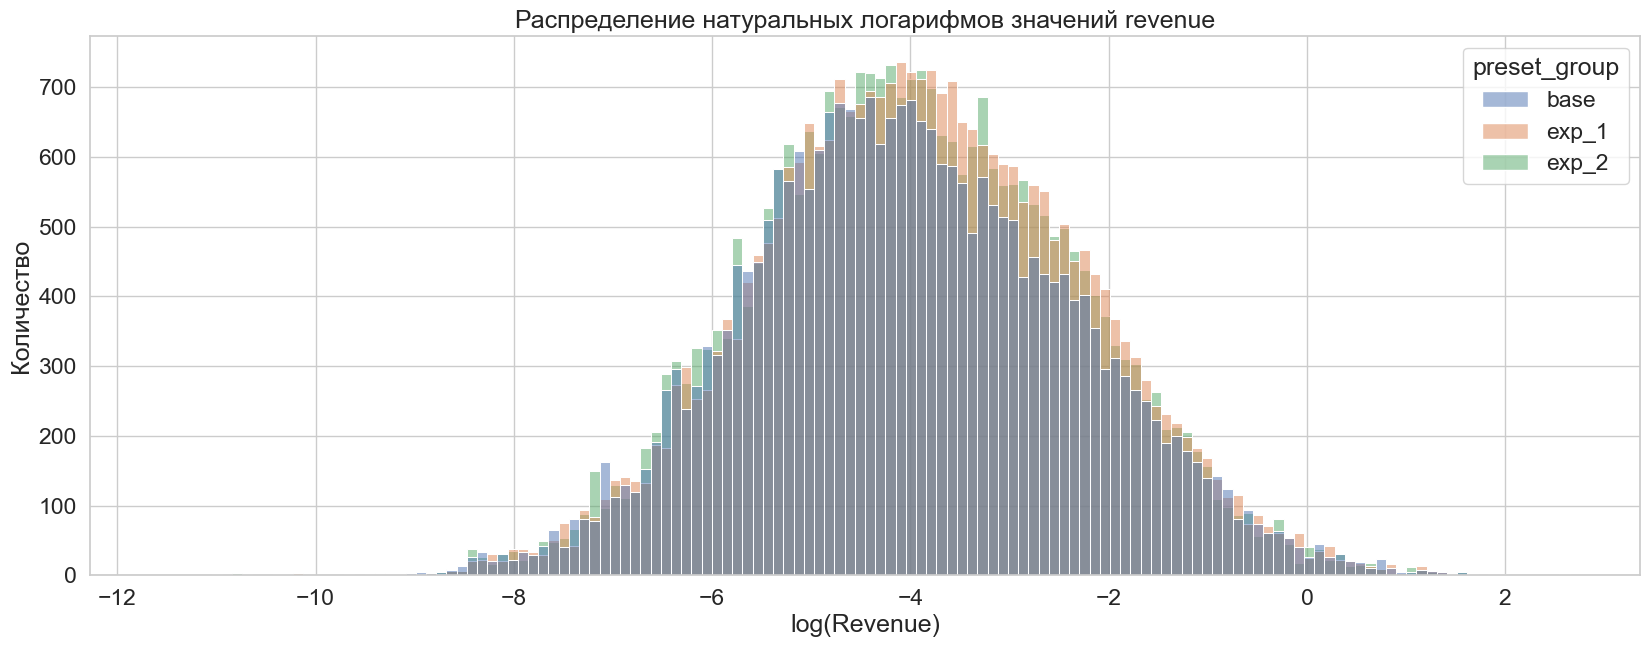

In [28]:
sns.histplot(x=np.log(dfe.revenue), hue=dfe.preset_group)
plt.title(f'Распределение натуральных логарифмов значений revenue')
plt.ylabel('Количество')
plt.xlabel('log(Revenue)')
;

Как будто бы значения для Эксперимента 1 расположены несколько правее, что может говорить о бОльших значениях revenue

Сначала я хотел применить непараметрический тест, но потом решил оценить доверительные интервалы для отдельных процентилей с помощью бутстрепа

In [29]:
# функция, которая делает бутстреп подвыборки
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

# функция для определения границ доверительного интервала
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [30]:
def confidence_intervals_for_percentiles(df_list, alpha, low_boundary, upper_boundary):   
    labels = ['base', 'exp1', 'exp2']
    colors = ['red', 'green', 'blue']
    
    for index, df in enumerate(df_list):
        scores_list = []
        
        for p in range(low_boundary, upper_boundary+10, 10):
    
            # Функция для подсчета процентиля
            def percentile(data):
                return np.percentile(data, q=p)  

            scores = list(map(percentile, get_bootstrap_samples(df, 1000)))
            scores_list.append(stat_intervals(scores, alpha))

        ax = sns.pointplot(scores_list,  capsize = 0.02, color=colors[index], label=labels[index],  markers='.')
        ax.set_xticklabels(labels=[x for x in range(low_boundary, upper_boundary+10, 10)])
        print(f'{labels[index]} ', [[round(x[0], 5), round(x[1], 5)] for x in scores_list])      
        
    plt.title(f'Доверительные интервалы для разных значений процентилей, уровень доверия: {(1 - alpha) * 100}%')
    plt.xlabel('Процентиль')
    plt.ylabel('Revenue')
    plt.legend(title = 'Эксперимент')

Возникает вопрос - на каком уровне доверия правильно оценивать ДУ. Брать стандартные 95% кажется некорректным из-за проблемы множественных сравнений. По факту мы оцениваем несколько доверительных интервалов, да еще и сразу для двух экспериментов и базовой версии. Я назначу уровень значимости 0.005, в 10 раз меньше стандартного. Считаю это значение достаточно консервативным, исходя из количества сравнений.

base  [[0.0, 0.0], [0.00174, 0.00209], [0.00459, 0.00504], [0.00844, 0.00911], [0.01466, 0.01574]]
exp1  [[0.00066, 0.00098], [0.00357, 0.00393], [0.00685, 0.00748], [0.01197, 0.01284], [0.01977, 0.02135]]
exp2  [[0.00062, 0.00093], [0.00316, 0.00349], [0.00631, 0.00688], [0.01091, 0.01175], [0.01819, 0.01949]]


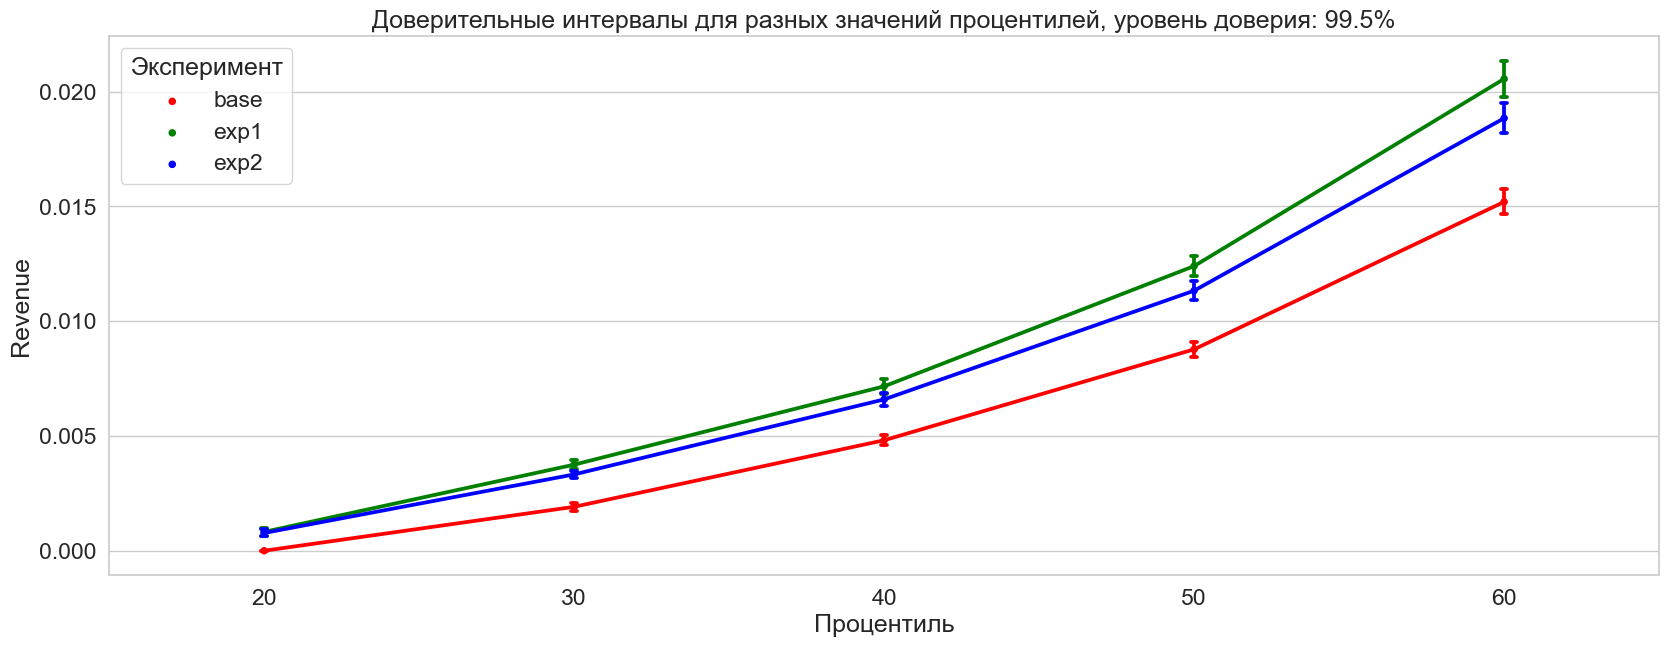

In [31]:
confidence_intervals_for_percentiles([dfb.revenue.values
                                      , dfe1.revenue.values
                                      , dfe2.revenue.values
                                     ], alpha=0.005
                                     , low_boundary = 20
                                     , upper_boundary = 60
                                    )

base  [[0.02544, 0.02768], [0.04979, 0.05413], [0.1172, 0.12941]]
exp1  [[0.03345, 0.03618], [0.06179, 0.06703], [0.13303, 0.14484]]
exp2  [[0.03141, 0.03399], [0.05805, 0.06241], [0.1237, 0.13545]]


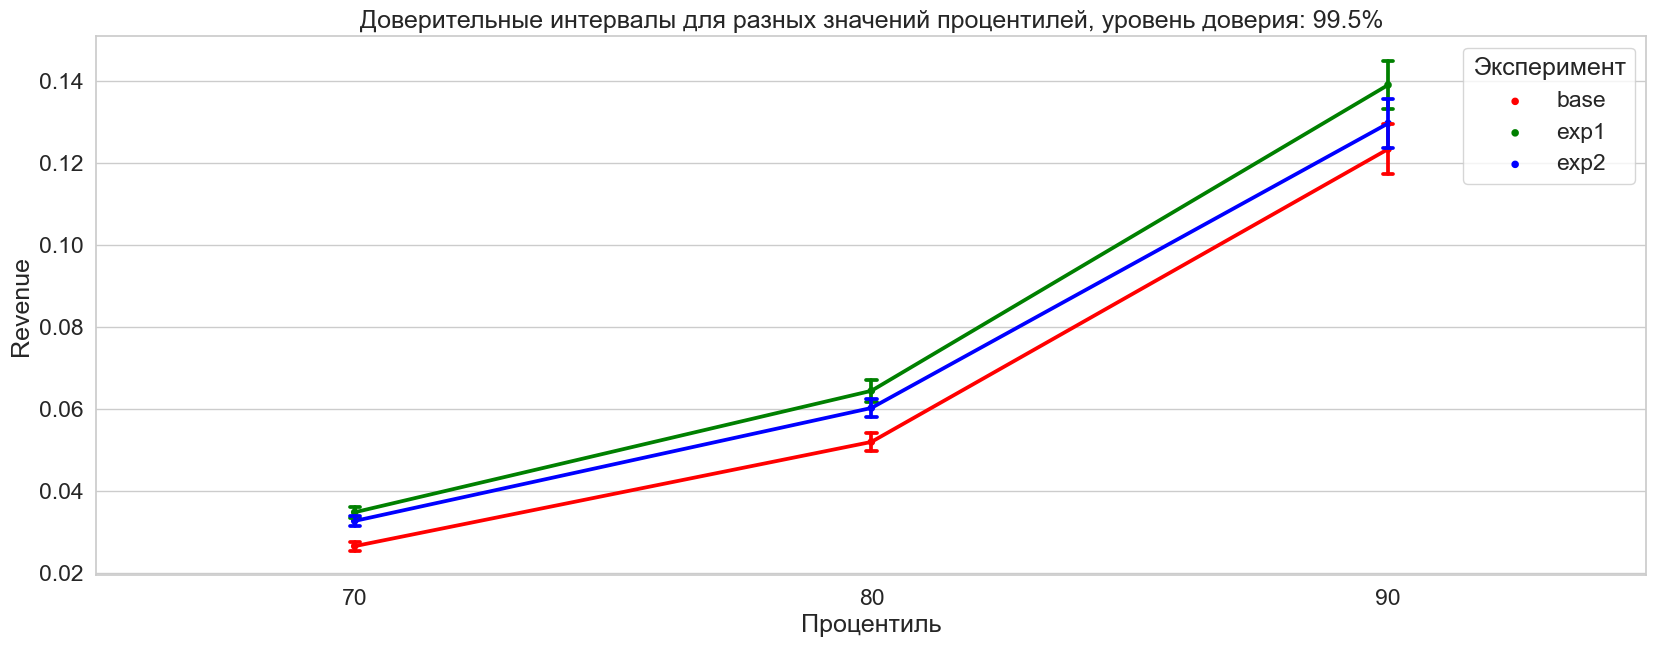

In [32]:
confidence_intervals_for_percentiles([dfb.revenue.values
                                      , dfe1.revenue.values
                                      , dfe2.revenue.values
                                     ], alpha=0.005
                                     , low_boundary = 70
                                     , upper_boundary = 90
                                    )

Промежуточные выводы:

   - обе версии эксперимента показывают стабильно лучшие результаты, чем базовая версия (кроме процентиля 90, где base и exp2 пересекаются)
   - exp1 в 4 случаях из 8 значимо выше, чем exp2. В остальных случаях доверительные интервалы пересекаются. Однако, стоит принимать во внимание то, что уровень значимости был выбран довольно консервативный, при этом линия, соединяющая средние значения ДУ, для exp1 на всем протяжении выше, чем exp2.

Посмотрим другие метрики.

Метрика retention показывает лучшие результаты для exp_1. При этом exp_2 хуже, чем и exp_1 и базовая версия.

In [33]:
pd.crosstab(dfe.preset_group, dfe.retention_D1)

retention_D1,0,1
preset_group,,
base,27350,7766
exp_1,27011,8105
exp_2,27838,7278


Я сравнивал их попарно, во всех случаях значение pvalue получилось достаточно низким, чтобы говорить о статистической значимости

In [34]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(dfe.preset_group, dfe.retention_D1).loc[['base', 'exp_1'], :])
p_val

0.0022917057487486007

In [35]:
# chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(dfe.preset_group, dfe.retention_D1).loc[['base', 'exp_2'], :])
# chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(dfe.preset_group, dfe.retention_D1).loc[['exp_1', 'exp_2'], :])

Метрика UsersQuestionRightAnswersPerAnswers распределена не нормально

''

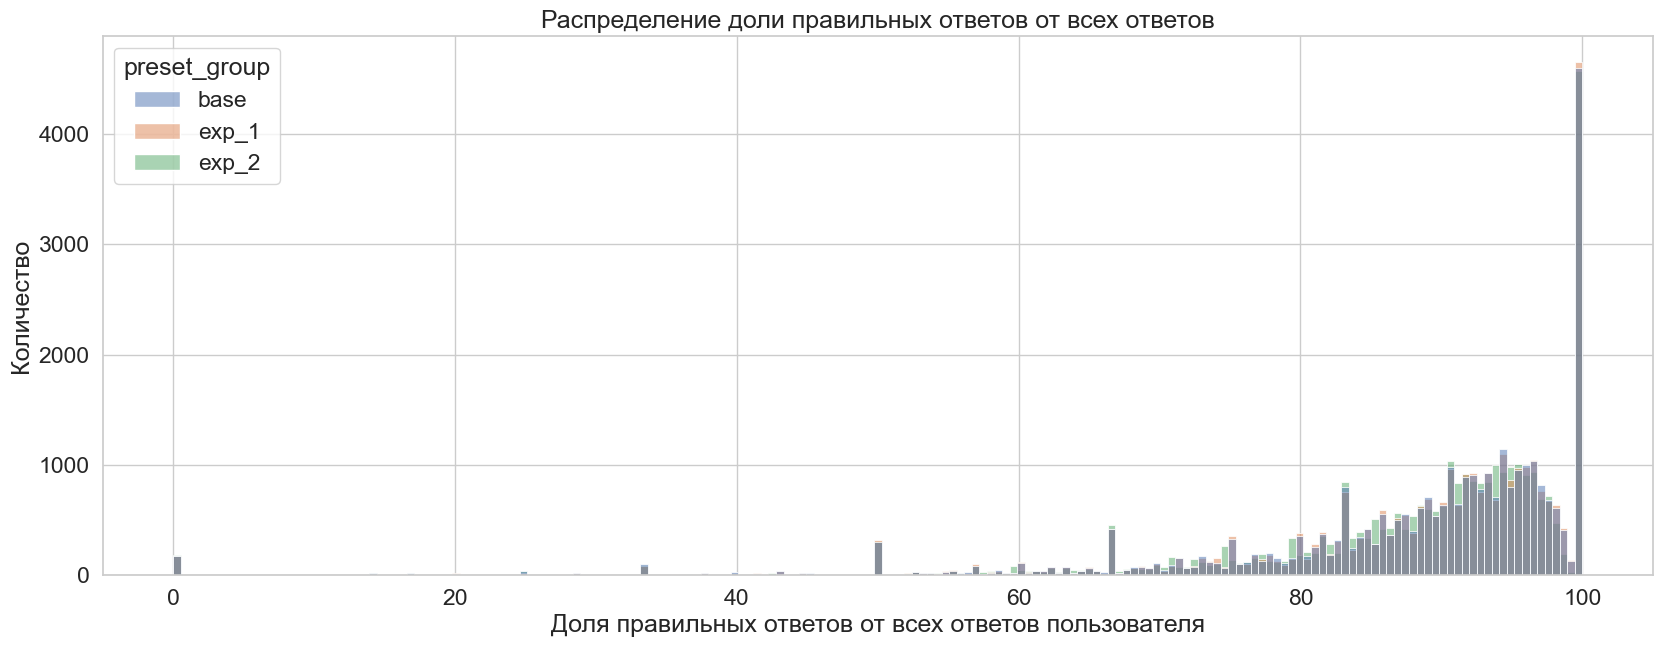

In [36]:
sns.histplot(x=dfe.UsersQuestionRightAnswersPerAnswers, hue=dfe.preset_group)
plt.title(f'Распределение доли правильных ответов от всех ответов')
plt.ylabel('Количество')
plt.xlabel('Доля правильных ответов от всех ответов пользователя')
;

Оценим доверительные интервалы для медианы

base  [[91.66667, 91.83673]]
exp1  [[91.66667, 91.83673]]
exp2  [[91.30435, 91.64474]]


''

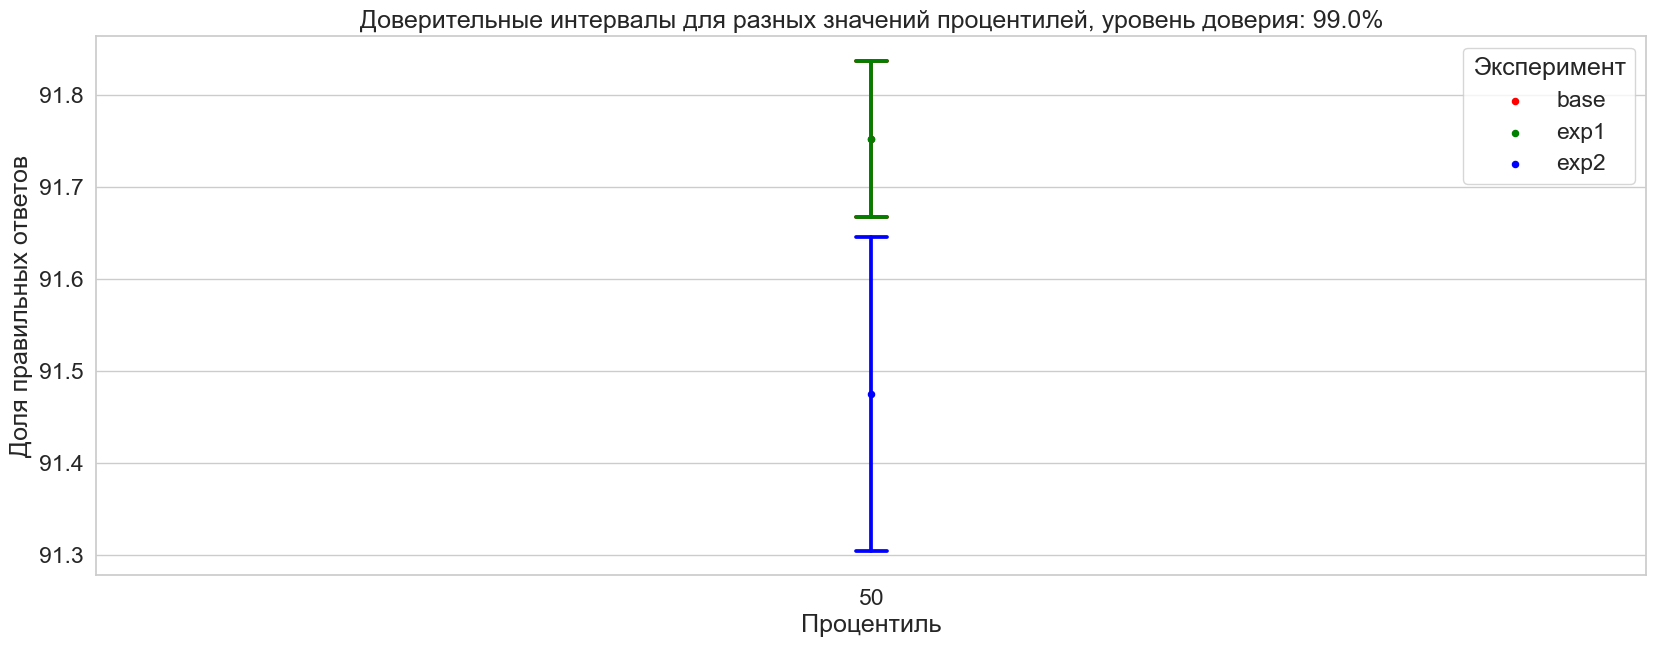

In [38]:
confidence_intervals_for_percentiles([dfb[dfb.UsersQuestionRightAnswersPerAnswers.isna() == False].UsersQuestionRightAnswersPerAnswers.values
                                      , dfe1[dfe1.UsersQuestionRightAnswersPerAnswers.isna() == False].UsersQuestionRightAnswersPerAnswers.values
                                      , dfe2[dfe2.UsersQuestionRightAnswersPerAnswers.isna() == False].UsersQuestionRightAnswersPerAnswers.values
                                     ], alpha=0.01
                                     , low_boundary = 50
                                     , upper_boundary = 50
                                    )

plt.ylabel('Доля правильных ответов')
;

Как видно, эксперимент 1 и базовая версия показали одинаковые результаты, статистических различий нет. Для эксперимента 2 значение несколько хуже.

**Вывод:** по совокупности факторов, главным из которых является статистическая значимость разницы по revenue, рекомендуется обновить приложение до версии, которая была использована в Эксперименте 1

### Задание 4

In [4]:
dfa = pd.read_csv('task_4.csv')
dfa.head(3)

,date,user_id,user_created_on,user_language,user_country,revenue
0,2022-12-01,576605997542425,2022-12-01,english,philippines,0.000000
1,2022-12-01,859653139126397,2022-12-01,english,philippines,0.000000
2,2022-12-01,84723636282736,2022-12-01,english,united_states,4.948572


In [5]:
dfa.date = pd.to_datetime(dfa['date'])
dfa.user_created_on = pd.to_datetime(dfa.user_created_on)

In [6]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745903 entries, 0 to 745902
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             745903 non-null  datetime64[ns]
 1   user_id          745903 non-null  int64         
 2   user_created_on  745903 non-null  datetime64[ns]
 3   user_language    745903 non-null  object        
 4   user_country     745903 non-null  object        
 5   revenue          745903 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 34.1+ MB


In [7]:
# Начало и конец рекламной кампании
print(dfa.date.min())
print(dfa.date.max())

2022-12-01 00:00:00
2023-02-01 00:00:00


#### Спрогнозировать общее значение revenue D30 для когорты 23.01.2023–29.01.2023

Поскольку нас интересует revenue за первые 30 дней пользования приложением, то удалим те строки, где между датой и датой регистрации больше 30 дней

In [8]:
dfa['date_delta'] = dfa.date - dfa.user_created_on 
dfa = dfa[dfa.date_delta <= '30 days']

In [9]:
dfa.shape

(549957, 7)

Посмотрим, как менялась revenue 30 дней для разных дат

In [10]:
rev_date = dfa.groupby('user_created_on', as_index=False).revenue.sum()
rev_date.head(2)

,user_created_on,revenue
0,2022-12-01,27820.111521
1,2022-12-02,26215.669534


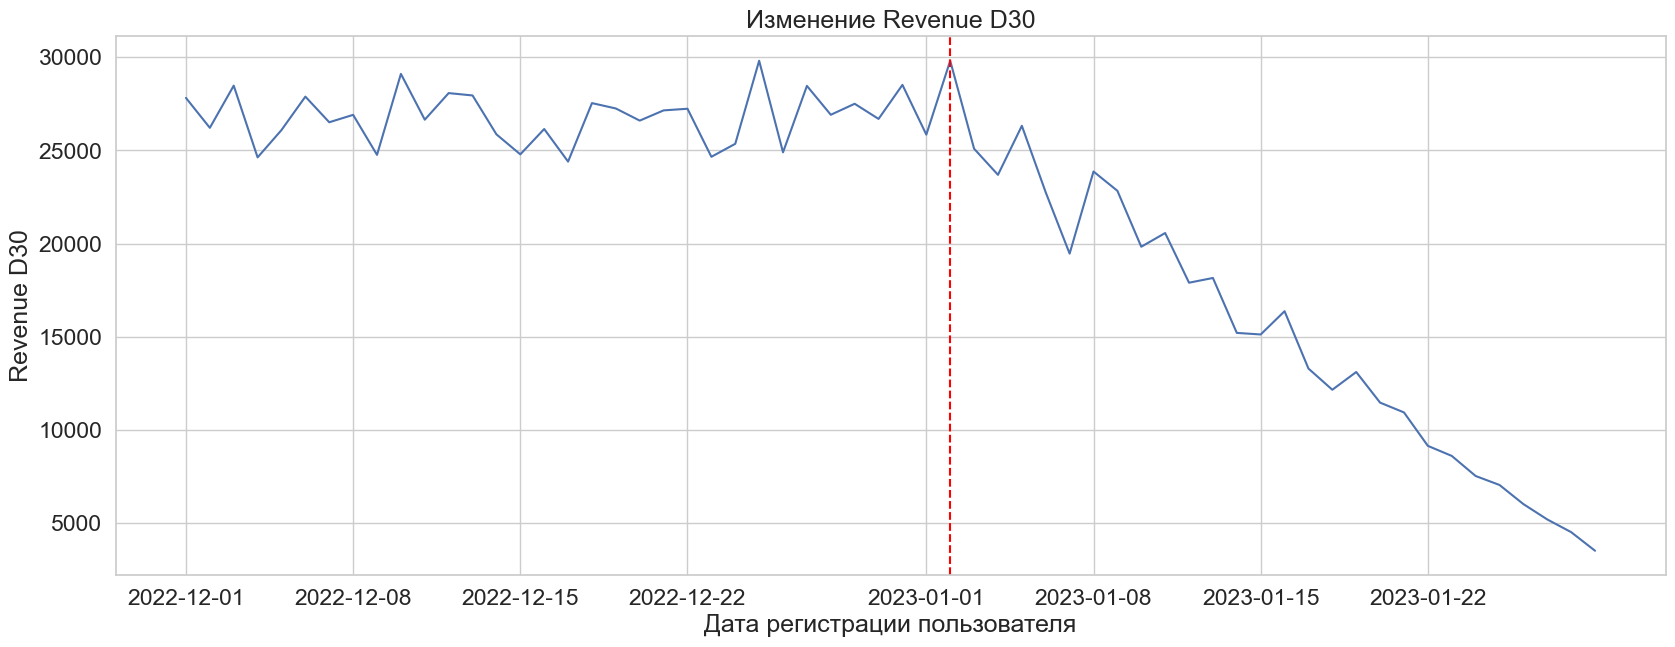

In [11]:
ax = sns.lineplot(data=rev_date, x='user_created_on', y='revenue')

border =  dfa.date.max() - pd.Timedelta(days=30)
# Добавляем вертикальную линию на график
ax.axvline(x=border, color='red', linestyle='--')

# Настраиваем параметры графика
plt.title("Изменение Revenue D30")
plt.xlabel("Дата регистрации пользователя")
plt.ylabel("Revenue D30")

plt.show()

**Красная линия** показывает границу, где у нас кончаются данные для расчета фактического revenue d30 (то есть за 30 дней до последней даты)

На графике видно, что значение revenue до красной линии колеблется примерно между 25 и 30 тыс. А потом равномерно уменьшается. Можно предположить, что и дальше среднее значение revenue сохраняется. Надо это проверить

К слову, аналогичная картина и при разбивке по языкам (по странам тоже - не стал приводить картинку)

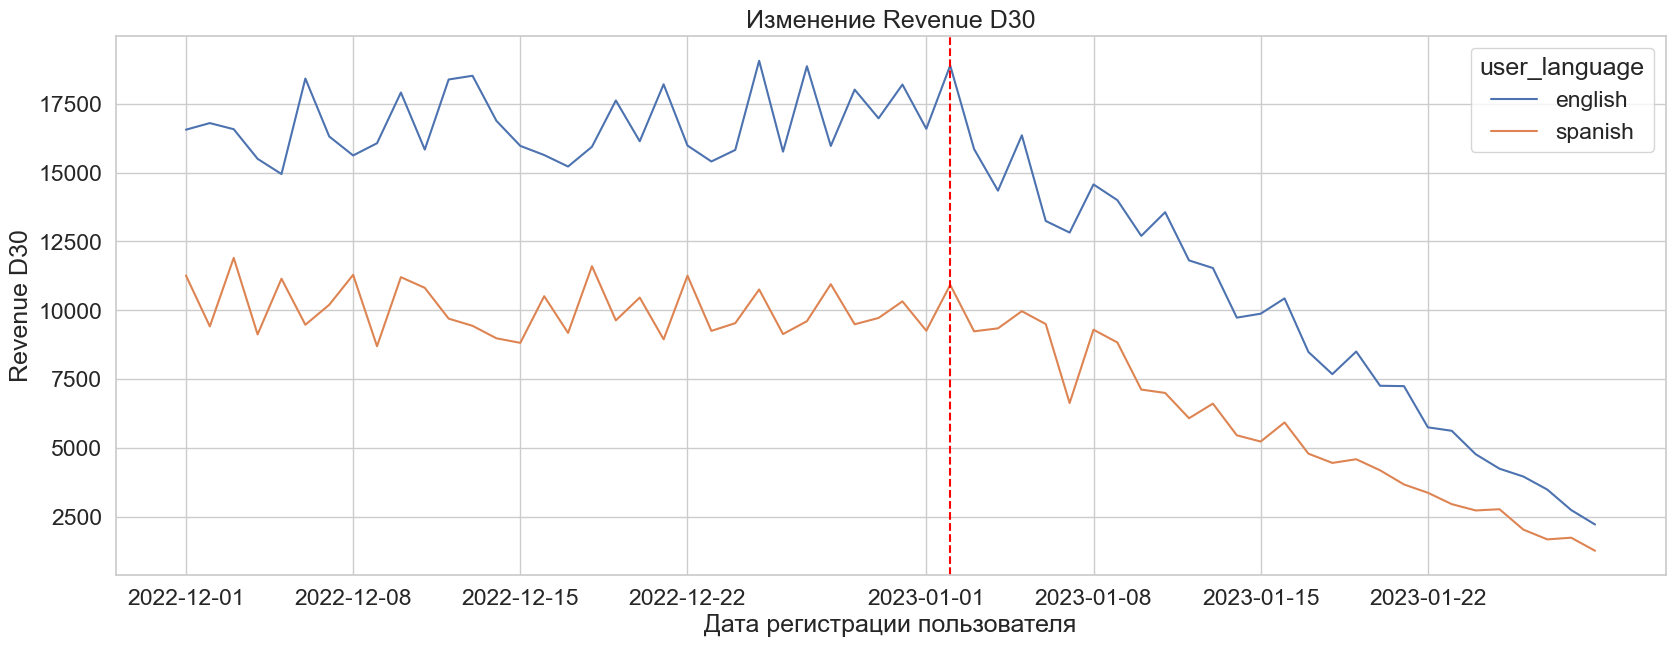

In [12]:
d = dfa.groupby(['user_created_on', 'user_language'], as_index=False).revenue.sum()
d.head(2)

ax = sns.lineplot(data=d, x='user_created_on', y='revenue', hue='user_language')

border =  dfa.date.max() - pd.Timedelta(days=30)
# Добавляем вертикальную линию на график
ax.axvline(x=border, color='red', linestyle='--')

# Настраиваем параметры графика
plt.title("Изменение Revenue D30")
plt.xlabel("Дата регистрации пользователя")
plt.ylabel("Revenue D30")
plt.show()

In [13]:
# среднее значение revenue d30 для каждого дня, где есть фактические данные
rev_date[rev_date.user_created_on <= border].revenue.mean()

26866.68124090309

In [14]:
# выделим даты, где у нас нет возможности посчитать revenue d30
rev_date_not_full = rev_date[rev_date.user_created_on > border]

In [15]:
# посчитаем, за сколько последующих дней есть данные
rev_date_not_full['revenue_days'] = (rev_date[rev_date.user_created_on > border].user_created_on.max() - 
                                            rev_date[rev_date.user_created_on > border].user_created_on)  \
                                            .dt.total_seconds().div(86400).astype(int) + 4

In [16]:
# поделим выручку на количество дней, получим среднее за день для каждого периода
rev_date_not_full['revenue_per_day'] = rev_date_not_full.revenue / rev_date_not_full.revenue_days

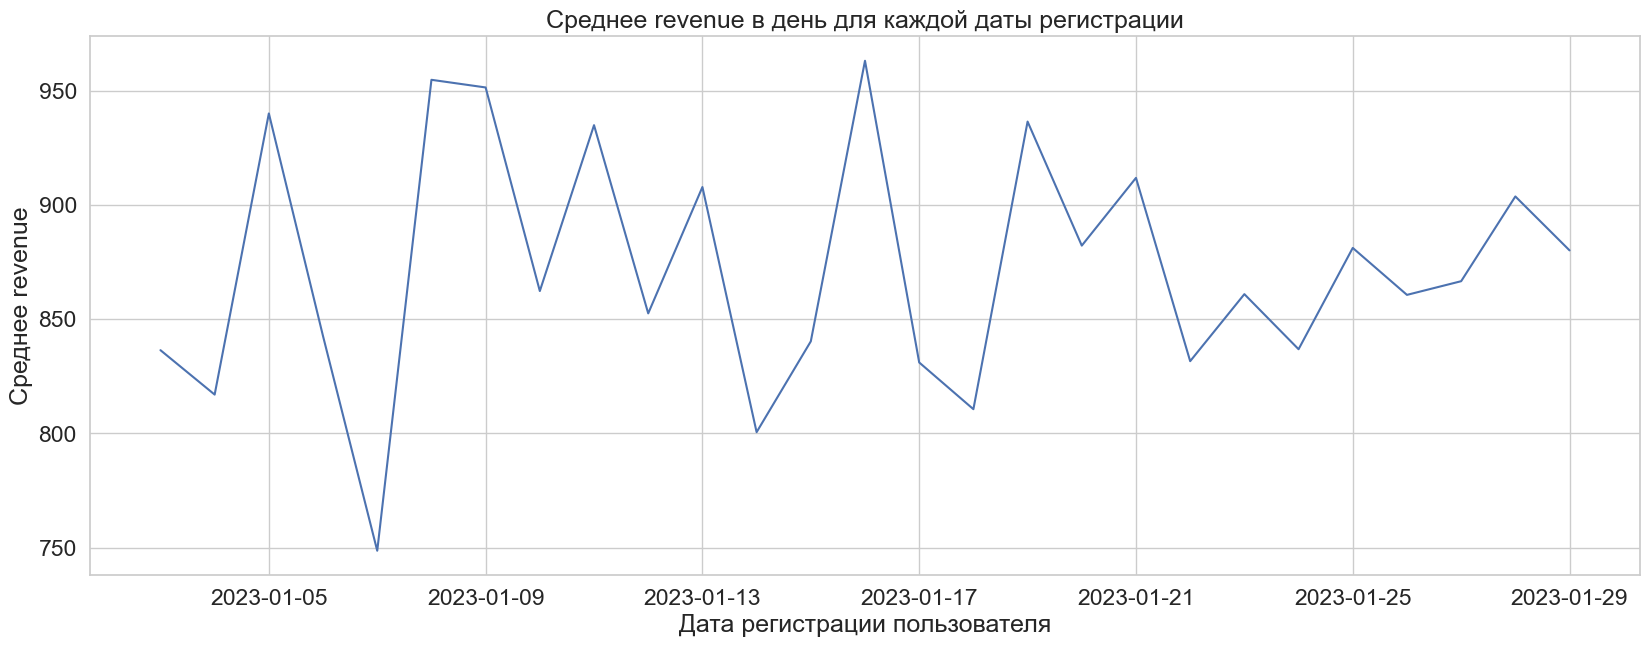

In [17]:
ax = sns.lineplot(data=rev_date_not_full, x='user_created_on', y='revenue_per_day')

# Настраиваем параметры графика
plt.title("Среднее revenue в день для каждой даты регистрации")
plt.xlabel("Дата регистрации пользователя")
plt.ylabel("Среднее revenue")

plt.show()

Визуально значение revenue не меняется.

Значит, тенденция сохраняется, и можно ожидать, что значение revenue D30 для когорты 23.01.2023–29.01.2023 будет примерно таким же, как и для когорт, для которых у нас есть данные. 
Посчитаем его

In [18]:
# cначала назначим номера декабрьским неделям, у которых есть полные данные (таких недель всего 3, так что проставлю вручную)
def week_num(df):
    if pd.Timestamp('2022-12-05') <= df.user_created_on <= pd.Timestamp('2022-12-11'):
        return 1
    elif pd.Timestamp('2022-12-12') <= df.user_created_on <= pd.Timestamp('2022-12-18'):
        return 2
    elif pd.Timestamp('2022-12-19') <= df.user_created_on <= pd.Timestamp('2022-12-25'):
        return 3

In [19]:
dfa['week_num'] = dfa.apply(week_num, axis=1)

In [20]:
dfa.groupby('week_num', as_index=False).revenue.sum()

,week_num,revenue
0,1.0,187936.298011
1,2.0,184781.203994
2,3.0,188076.440876


Значения для разных недель близки, так что предлагаю для оценки взять простое среднее

In [21]:
prediction = dfa.groupby('week_num', as_index=False).revenue.sum().revenue.mean()
int(prediction)

186931

**Вывод:** для когорты 23.01.2023–29.01.2023 значение revenue D30 будет около 186931

(или точне было бы назвать диапазон - от 184 до 188 тысяч)

#### Оценить эффективность рекламной кампании

Оцениваем рекламную кампанию по привлечению новых пользователей.
Мы уже имеем данные о полученном доходе, и можем рассчитать средний доход на пользователя ARPU.   

Необходимо узнать расходы, сколько денег мы на нее потратили. Тогда мы сможем посчитать расходы на привлечение одного пользователя (Cost per acqusition).

Посчитав разницу между расходом и доходом и умножив на количество пользователей, можно вычислить прибыль (стоит учесть и другие издержки, если они есть - например, увеличение трафика может потребовать внедрения новых серверов/мощностей).

Если у нас есть доступ к данным по кликам/показам рекламы, то их тоже можно посмотреть. Например, чтобы сравнить CTR с прошлыми рекламными кампаниями.